# Uncertainty Estimation Practical Part I
There are many ways to estimate predictive uncertainty in deep learning. However, in this practical, we focus on simple yet effective methods. One such method that has achieved impressive performance is the Deep Ensembles method[[1]]. In this practical, we first study this method in Part I, then a recent extension in Part II.

[1]:https://arxiv.org/pdf/1612.01474.pdf


## Simple and Scalable Predictive Uncertainty Estimation Using Deep Ensembles -- Lakshminarayanan B, Pritzel A, Blundell C. [1]

### Abstract:
Deep neural networks (NNs) are powerful black box predictors that have recently achieved impressive performance on a wide spectrum of tasks. Quantifying predictive uncertainty in NNs is a challenging and yet unsolved problem. Bayesian NNs, which learn a distribution over weights, are currently the state-of-the-art for estimating predictive uncertainty; however these require significant modifications to the training procedure and are computationally expensive compared to standard (non-Bayesian) NNs. We propose an alternative to Bayesian NNs that is simple to implement, readily parallelizable, requires very little hyperparameter tuning, and yields high quality predictive uncertainty estimates. Through a series of experiments on classification and regression benchmarks, we demonstrate that our method produces well-calibrated uncertainty estimates which are as good or better than approximate Bayesian NNs. To assess robustness to dataset shift, we evaluate the predictive uncertainty on test examples from known and unknown distributions, and show that our method is able to express higher uncertainty on out-of-distribution examples. We demonstrate the scalability of our method by evaluating predictive uncertainty estimates on ImageNet.

### Notations
Assume we have i.i.d. training data points $(\boldsymbol{x}, y)$, where $\boldsymbol{x} \in \mathbb{R}^D$ is the D-dimensional input features. And for a classification problem with $K$ classes, $y \in \{1,\ldots,K\}$; for a regression problem, $y \in \mathbb{R}$. We use a NN with parameters $\theta$ to model the probablistic predictive distribution $p_{\theta}(y|\boldsymbol{x})$ over the labels.

### Proper scoring rules
Scoring rules measure the quality of predictive uncertainty [2]. Suppose we have $(y,\boldsymbol{x})$ following the true distribution $q(y,\boldsymbol{x})$, and we want to evaluate the quality of the predictive distribution, $p_{\theta}(y|\boldsymbol{x})$. The scoring rule, a function, $S(p_{\theta},(y,\boldsymbol{x}))$, assigns a numerical score to the predictive distribution $p_{\theta}(y|\boldsymbol{x})$. Here we consider scoring rules where a high score means better quality. The expected scoring rule is then $S_{\mathbb{E}}(p_{\theta},q)=\int q(y,\boldsymbol{x}) S(p_{\theta},(y,\boldsymbol{x}))dyd\boldsymbol{x}$. A *proper scoring rule* is, for all $p_{\theta}$ and $q$, $S_{\mathbb{E}}(p_{\theta},q) \leq S_{\mathbb{E}}(q,q)$ with equality if and only if $p_{\theta}(y|\boldsymbol{x})=q(y|\boldsymbol{x})$. Since a larger value $S_{\mathbb{E}}(p_{\theta},q)$ means a better quality of the predictive uncertainty, we could train NNs by minimizing the loss $\mathcal{L}(\theta)=-S_{\mathbb{E}}(p_{\theta},q)$.


Log-likelihood, $\log p_{\theta}(y|\boldsymbol{x})$, turns out to be a proper scoring rule due to [Gibbs inequality]:

\begin{equation}
S_{\mathbb{E}}(p_{\theta},q)=\mathbb{E}_{q(\boldsymbol{x})} q(y|\boldsymbol{x}) \log p_{\theta}(y|\boldsymbol{x}) \leq \mathbb{E}_{q(\boldsymbol{x})} q(y|\boldsymbol{x}) \log q(y|\boldsymbol{x}). 
\end{equation}


Thus, minimizing the negative log-likelihood (NLL), which is equivalent to the softmax cross entropy loss in classification, is a proper scoring rule. Interestingly minimizing the squared error between the predictive probability of a label and one-hot encoding of the correct label, is also a proper scoring rule known as the Brier score. In regression, if we assume $p_{\theta}$ to be Gaussian $\mathcal{N}(\mu_{\theta}(\boldsymbol{x}), \sigma_{\theta}^2(\boldsymbol{x}))$: 

**========================**
####**TODO**: Derive the NLL loss for Gaussian assumption.
**========================**

\begin{align}
-\log p_{\theta}(y|\boldsymbol{x}) &=  \frac{1}{2}\log(2\pi) + \log(\sigma_{\theta}(\boldsymbol{x})) + \frac{(y-\mu_{\theta}(\boldsymbol{x}))^2}{2\sigma_{\theta}^2(\boldsymbol{x})} 
\end{align}

Of course we can model the $p_{\theta}$ to be other distributions, e.g. [Laplacian distribution], which corresponds to L1 loss, MAE, rather than Gaussian distribution, which corresponds to L2 loss, MSE. If we assume $p_{\theta}$ to be Laplacian $\mathcal{L}(\mu_{\theta}(\boldsymbol{x}), \sigma_{\theta}(\boldsymbol{x}))$, with mean $\mu_{\theta}(\boldsymbol{x})$ and variance $\sigma_{\theta}(\boldsymbol{x})$:

**========================**
####**TODO**: Derive the NLL loss for Laplacian assumption.
**========================**

\begin{align}
-\log p_{\theta}(y|\boldsymbol{x}) &= \log(2\sigma_{\theta}(\boldsymbol{x})) + \frac{|y-\mu_{\theta}(\boldsymbol{x})|}{\sigma_{\theta}(\boldsymbol{x})}
\end{align}


### Adversarial training
Adversarial examples (see [[3]] and [[4]]) are those which are very close to the original training examples but are misclassified by the NN. In [[4]], the authors proposed the *fast gradient sign method* as a fast solution to generate adversarial examples. Given $(\boldsymbol{x},y)$ and the loss $\ell(\theta,\boldsymbol{x},y)$, we can use the fast gradient sign method to generate an adversarial example as $\boldsymbol{x}'=\boldsymbol{x}+\epsilon \text{sign}\big(\nabla_{\boldsymbol{x}}\ell(\theta,\boldsymbol{x},y)\big)$, where $\epsilon$ is a small value to bound the perturbation. The procedure to use this adversarial example as an additional training sample to augument the training set, referred to as *adversarial training* was found to improve the classifier's robustness [[4]].  

There are more than one way to generate adversarial examples, for example, *virtual adversarial training* (VAT)[[5]], which does not require to know the true target $y$, could be used in *semi-supervised learning* (SSL).

### Ensembles
In general there are two classes of ensembles: *randomization*-based approaches and *boosting*-based approaches. Here we only focus on randomization-based approaches since it is more suitable for parallel computation. In practice, random initialization of the NN parameters $\theta$ and with random shuffling of the data points during training were found to be sufficient to obtain good performance. During inference, the ensemble is treated as a uniformly-weighted mixture model and the predictions are combined as $p(y|\boldsymbol{x})=M^{-1}\sum_{m=1}^{M}p_{\theta_m}(y|\boldsymbol{x},\theta_m)$. For classification, this corresponds to averaging the predicted probabilities. For regression, if we assume a Gaussian distribution over label $y$ given point $\boldsymbol{x}$, i.e. $p(y|\boldsymbol{x})=\mathcal{N(\mu,\sigma)}$ for some $\mu$ and $\sigma$, then the prediction's distribution is a mixture of Gaussian distributions (as we have one Gaussian output for each model in the ensemble). We then approximate the ensemble prediction as a Gaussian, whose mean and variance are respectively the mean and variance of the mixture:
\begin{align}
\mu_{\ast}(\boldsymbol{x})&=M^{-1}\sum_{m=1}^{M}\mu_{\theta_m}(\boldsymbol{x})\\
\sigma^2_{\ast}(\boldsymbol{x})&=M^{-1}\sum_{m=1}^{M}(\sigma^2_{\theta_m}(\boldsymbol{x}) + \mu^2_{\theta_m}(\boldsymbol{x})) - \mu^2_{\ast}(\boldsymbol{x}).
\end{align}

And if we assume a Laplacian distribution over label $y$ given input $\boldsymbol{x}$, then the mean and variance of the mixture is:
\begin{align}
\mu_{\ast}(\boldsymbol{x})&=M^{-1}\sum_{m=1}^{M}\mu_{\theta_m}(\boldsymbol{x})\\
\sigma^2_{\ast}(\boldsymbol{x})&=M^{-1}\sum_{m=1}^{M}(2\sigma^2_{\theta_m}(\boldsymbol{x}) + \mu^2_{\theta_m}(\boldsymbol{x})) - \mu^2_{\ast}(\boldsymbol{x}).
\end{align}


[1]:https://arxiv.org/pdf/1612.01474.pdf
[2]:https://viterbi-web.usc.edu/~shaddin/cs699fa17/docs/GR07.pdf 
[3]:https://arxiv.org/pdf/1312.6199.pdf
[4]:https://arxiv.org/pdf/1412.6572.pdf
[5]:https://arxiv.org/abs/1704.03976
[Gibbs inequality]:https://en.wikipedia.org/wiki/Gibbs%27_inequality
[Laplacian distribution]:https://en.wikipedia.org/wiki/Laplace_distribution

## Regression on toy dataset 

In [21]:
#!pip install -U matplotlib

In [35]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import random
import matplotlib.pyplot as plt 
from jax.scipy.special import logsumexp
import numpy as np
from jax.example_libraries import optimizers
import time 
import sys
# Add this at the top of your cell


Note that for the sake of numerical stability, we assume 
that the prediction variance is modeled as follows:
$$
\begin{align}
\sigma &= \log(1 + \exp(\rho)) + \epsilon\\
       &= \text{softplus}(\rho)+ \epsilon
\end{align}
$$
where $\rho$ is the model output in $\mathbb{R}$, and $\sigma$ is in $(\epsilon,+\infty)$. Usually, $\epsilon$, a very small number, is used to avoid division by zero.

In [ ]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key, scale):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

def predict(params, inputs):
    # per-example predictions
    activations = inputs
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = jax.nn.relu(outputs)

    final_w, final_b = params[-1]
    scores = jnp.dot(final_w, activations) + final_b
    
    mean, rho = jnp.split(scores, 2)
    
    variance = jax.nn.softplus(rho) + 1e-6
    return mean, variance # for NLL loss
    # return scores # for MSE loss

batched_predict = vmap(predict, in_axes=(None, 0))

def loss(params, inputs, targets):
    preds = batched_predict(params, inputs)
    return jnp.mean(jnp.square(preds - targets))

def loss_l1(params, inputs, targets):
    preds = batched_predict(params, inputs)
    return jnp.mean(jnp.absolute(preds - targets))

def NLLloss_gaussian(params, inputs, targets):
    """ 
    Negative log-likelihood loss function. 
    ==============================
    TODO: Implementation required.
    ==============================
    The ``inputs`` argument and ``targets`` of this function are both of shape (N,1)=(#examples, 1).
    1. Feed forward the data to NN to obtain mean and variance (use batched_predict function)
    2. Calculate the negative log-likelihood using the outputs of the NN, based on Gaussian assumption (the loss should be a scalar)
    """
    mean, variance = batched_predict(params, inputs)
    nll_vector = 0.5 * jnp.log(2*jnp.pi) + 0.5 * jnp.log(variance) + ((targets - mean)**2)  / (2 * variance)
    nll_loss = jnp.mean(nll_vector)

    #raise NotImplementedError("Task: Implement!")
    #nll_loss = NotImplemented
    return nll_loss

def NLLloss_laplacian(params, inputs, targets):
    """ 
    Negative log-likelihood loss function. 
    ==============================
    TODO: Implementation required.
    ==============================
    The ``inputs`` argument and ``targets`` of this function are both of shape (N,1)=(#examples, 1).
    1. Feed forward the data to NN to obtain mean and variance (use batched_predict function)
    2. Calculate the negative log-likelihood using the outputs of the NN, based on Laplacian assumption (the loss should be a scalar)
    """
    mean, variance = batched_predict(params, inputs)
    nll_vector = jnp.log(2 * variance) + jnp.abs(targets - mean) / variance
    nll_loss = jnp.mean(nll_vector)
    #raise NotImplementedError("Task: Implement!")
    #nll_loss = NotImplemented
    return nll_loss

def NLLlossAT_gaussian(params, inputs, targets, eps=0.08):
    """ 
    Negative log-likelihood loss function with adversarial training 
    ==============================
    TODO: Implementation required.
    ==============================
    The ``inputs`` argument and ``targets`` of this function are both of shape (N,1)=(#examples, 1).
    1. Use the ``value_and_grad`` function together with the 
       ``NLLloss_gaussian`` function you implemented to get
       the loss value and the gradients with respect to the ``inputs``.
       Note that you also need to pass ``argnums`` to ``value_and_grad``.
    2. Generate adversarial examples. Note that you need to call jnp.array
       on gradients to be able to compute the sign. 
       So use jnp.sign(jnp.array(grads)) instead of jnp.sign(grads).
    3. Calculate the NLL loss based on the adversarial examples and average the two losses
    """
    value, grads = value_and_grad(NLLloss_gaussian, argnums=1)(params, inputs, targets)
    nll = NLLloss_gaussian(params, inputs, targets)
    sign_gradients = jnp.sign(jnp.array(grads))
    adversarial_inputs  = inputs + sign_gradients * eps
    
    nll_ad = NLLloss_gaussian(params, adversarial_inputs, targets)
    
    return (nll + nll_ad)/2

def NLLlossAT_laplacian(params, inputs, targets, eps=0.08):
    """ 
    Negative log-likelihood loss function with adversarial training 
    ==============================
    TODO: Implementation required.
    ==============================
    The ``inputs`` argument and ``targets`` of this function are both of shape (N,1)=(#examples, 1).
    1. Use the ``value_and_grad`` function together with the 
       ``NLLloss_laplacian`` function you implemented to get
       the loss value and the gradients with respect to the ``inputs``.
       Note that you also need to pass ``argnums`` to ``value_and_grad``.
    2. Generate adversarial examples. Note that you need to call jnp.array
       on gradients to be able to compute the sign. 
       So use jnp.sign(jnp.array(grads)) instead of jnp.sign(grads).
    3. Calculate the NLL loss based on the adversarial examples and average the two losses
    """

    value, grads = value_and_grad(NLLloss_laplacian, argnums=1)(params, inputs, targets)
    nll = NLLloss_laplacian(params, inputs, targets)
    sign_gradients = jnp.sign(jnp.array(grads))
    adversarial_inputs  = inputs + sign_gradients * eps
    
    nll_ad = NLLloss_laplacian(params, adversarial_inputs, targets)
    
    return (nll + nll_ad)/2



@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    # value, grads = value_and_grad(loss)(params, x, y)

    # value, grads = value_and_grad(NLLloss_gaussian)(params, x, y)
    #value, grads = value_and_grad(NLLlossAT_gaussian)(params, x, y)

    # value, grads = value_and_grad(NLLloss_laplacian)(params, x, y)
    value, grads = value_and_grad(NLLlossAT_laplacian)(params, x, y)

    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

def data_set(points=20, xrange=(-4, 4), std=3.):
    xx = jnp.array([[np.random.uniform(*xrange)] for i in range(points)])
    yy = jnp.array([[x**3 + np.random.normal(0, std)] for x in xx])
    return xx.reshape(-1,1), yy.reshape(-1,1)

In [ ]:
# network parameters

layer_sizes = [1, 10, 6, 30, 2] 

# param_scale = 0.02
num_epochs = 600
step_size = 8e-2

# to ensure reproducibility
np.random.seed(173)
xx, yy = data_set(points=40, xrange=(-4, 4), std=3.) # generate data set of 20 samples
x = np.linspace(-6, 6, 100).reshape(-1, 1)
y = x**3
x = jnp.array(x)
y = jnp.array(y)

# number of ensembles 
M = 6
params_all = [None]*M

opt_state_all = [None]*M
mean_all, var_all = [], []
opt_init, opt_update, get_params = optimizers.adam(step_size)

for i in range(M):
    # use random seed to randomly initialize the NN
    SEED = 100+abs(int(np.random.normal(0,1)*10000))
    
    np.random.seed(SEED)
    param_scale = abs(np.random.normal(0,0.1))
    print("----------training network "+str(i)+"------------param_scale "+str(param_scale))
    params_all[i] = init_network_params(layer_sizes, random.PRNGKey(i*10), param_scale)
    
    opt_state_all[i] = opt_init(params_all[i])

    log_acc_train, log_train_loss = [], []

    for epoch in range(num_epochs):
        start_time = time.time()

        params_all[i] = get_params(opt_state_all[i])
        params_all[i], opt_state_all[i], train_loss = update(params_all[i], xx, yy, opt_state_all[i])

        if epoch == 0:
            print("initial loss: ",train_loss)
        epoch_time = time.time() - start_time

        log_train_loss.append(train_loss)

    print("final loss: ",train_loss)

    mean, var = batched_predict(params_all[i], x)
    
    mean_all.append(mean)
    var_all.append(var)

mean_all = np.array(mean_all)
var_all = np.array(var_all)

mean_ = mean_all.mean(axis=0)
# ==============================
# TODO: Implementation required.
# ==============================
# Calculate the variance for the mixture model, according to your assumption, Gaussian or Laplacian.

#Gaussian assumption
mean_gaussian = jnp.sum(mean_all, axis=0) / M
var_gaussian = jnp.sum(var_all + mean_all**2, axis=0) / M - mean_gaussian**2

#laplacian assumption
mean_laplacian = jnp.sum(mean_all, axis=0) / M
var_laplacian = jnp.sum(2 * var_all + mean_all**2, axis=0) / M - mean_laplacian**2
#raise NotImplementedError("Task: Implement!")
var_ = var_laplacian

std_ = np.sqrt(var_)


----------training network 0------------param_scale 0.05341477341995916
initial loss:  437.74832
final loss:  3.6199024
----------training network 1------------param_scale 0.12899350046504218
initial loss:  514.4397
final loss:  3.021054
----------training network 2------------param_scale 0.06450740460784611
initial loss:  408.90042
final loss:  2.748788
----------training network 3------------param_scale 0.1859958185502153
initial loss:  403.6508
final loss:  2.5683818
----------training network 4------------param_scale 0.021813948079358225
initial loss:  435.45258
final loss:  3.0358312
----------training network 5------------param_scale 0.17893712367557665
initial loss:  462.94785
final loss:  3.5936768


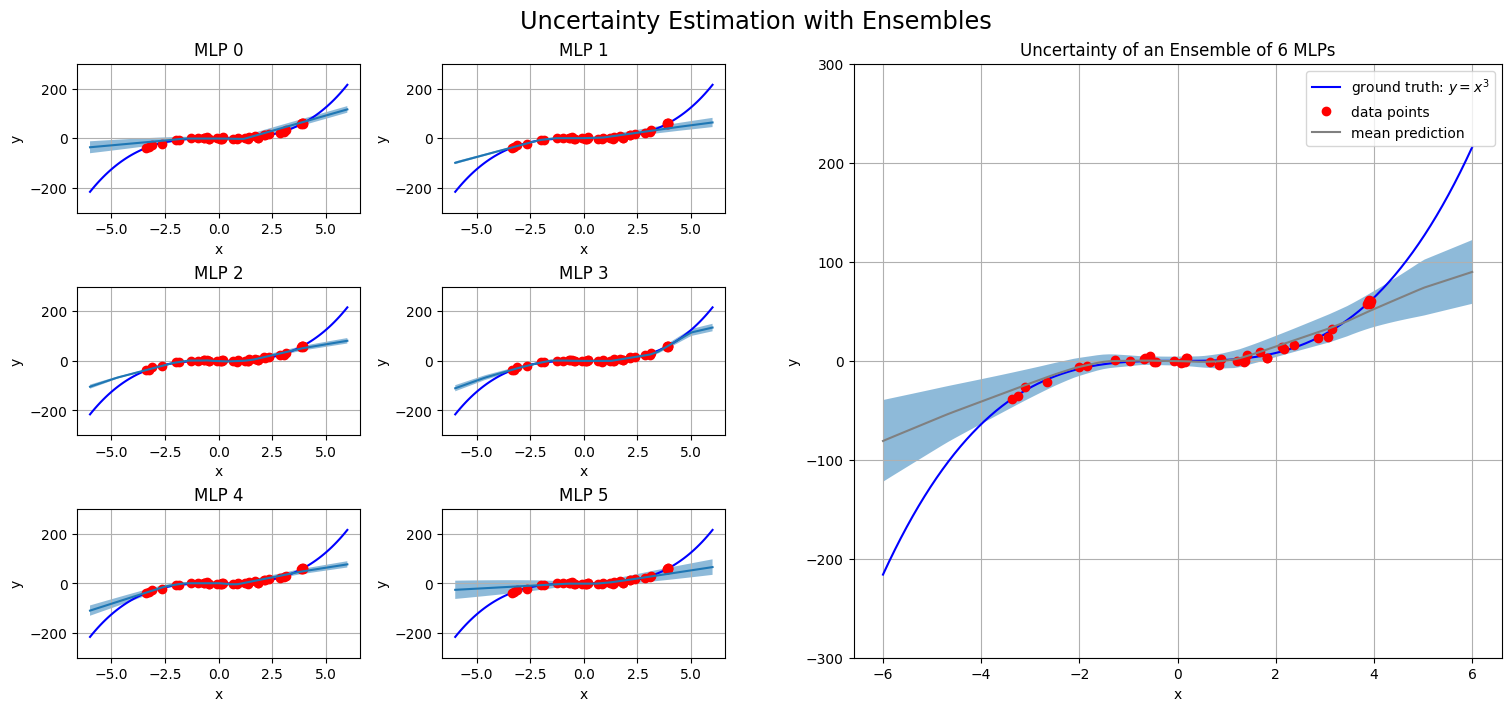

In [79]:
# visualize ensemble output
fig = plt.figure(constrained_layout=True, 
                 figsize=(15, 7),
                 dpi=100)
fig.suptitle('Uncertainty Estimation with Ensembles',
             fontsize='xx-large')
subfigs = fig.subfigures(1, 2, wspace=0.07)
axs_left = subfigs[0].subplots(3, 2)
for i,ax in zip(range(M),axs_left.flat):
    ax.plot(x, y, "b-")
    ax.plot(xx,yy,"or")
    ax.plot(x, mean_all[i])
    ax.fill_between(x.reshape(-1,), (mean_all[i]-np.sqrt(var_all[i])).reshape(-1,), (mean_all[i]+np.sqrt(var_all[i])).reshape(-1,),alpha=0.5)
    ax.grid()
    ax.set_title("MLP " + str(i))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_ylim((-300,300))

axs_right = subfigs[1].subplots(1, 1)
axs_right.plot(x, y, "b-", label="ground truth: $y=x^3$")
axs_right.plot(xx,yy,"or", label="data points")
axs_right.plot(x, mean_, label="mean prediction", color="grey")
axs_right.fill_between(x.reshape(-1,), (mean_-std_).reshape(-1,), (mean_+std_).reshape(-1,),alpha=0.5)
axs_right.grid()
axs_right.set_title("Uncertainty of an Ensemble of "+str(M)+" MLPs")
axs_right.set_xlabel("x")
axs_right.set_ylabel("y")
axs_right.set_ylim((-300,300))
axs_right.legend()

**Discussion points:**
* In terms of regression, compared to only use NLL loss with a single network, what is the effect of adding Adversarial Training? How about adding ensembles of M networks? 
* How is the number of networks, M, affecting the prediction and uncertainty estimation?

## Classification on [toy dataset] : 
[toy dataset]: https://cs231n.github.io/neural-networks-case-study/

The NLL loss for categorical assumption is:
\begin{align}
-\log p_{\theta}(y|\boldsymbol{x}) &= -\log(\prod_{i=1}^k p^{y_i})\\
&= -\sum_{i=1}^k\log( p^{y_i}_i)\\
&= -\sum_{i=1}^ky_i\log(p_i)\\
&= -\log(p_i)
\end{align}
where, for notational simplicity we assume $y=[y_1,y_2,\dots,y_k]$ is the one-hot encoded representation of the random variable $y$.

In [ ]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

def generate_datasets(N,K,noise):
    X = np.zeros((N*K,D)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels

    for j in range(K):
        ix = range(N*j,N*(j+1))
        r = np.linspace(0.0,1.,N) # radius
        t = np.linspace(j*8,(j+1)*8,N) + np.random.randn(N)*noise * (r+1.0) # theta
        print(j, np.amin(t), np.amax(t))
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    X = jnp.array(X)
    y = jnp.array(y)
    y_onehot = one_hot(y, K)
    return X, y, y_onehot

def shuffle_dataset(X, y, y_onehot, seed):
    indices = jax.random.permutation(seed, jnp.arange(X.shape[0]))
    X_shuffled = jnp.take(X, indices, axis=0)
    y_oh_shuffled = jnp.take(y_onehot, indices, axis=0)
    y_shuffled = y[indices]
    return X_shuffled, y_shuffled, y_oh_shuffled

0 -0.6210700567572351 9.160761050479454
1 7.506810982132371 16.88345105834359
2 15.192239293196302 25.21297645733773
Training X: (3000, 2)
Training y: (3000,)


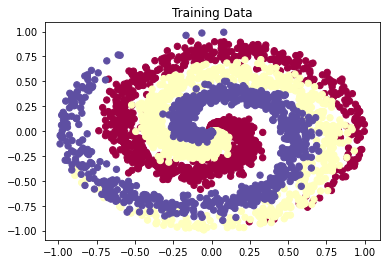

In [ ]:
N = 1000 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes

np.random.seed(0)
X, y, y_onehot = generate_datasets(N, K, noise=0.3)

# lets visualize the data:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.title("Training Data")
print("Training X:", X.shape)
print("Training y:", y.shape)

In [ ]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-1):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

@jit
def predict(params, image):
    # per-example predictions
    activations = image
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = jax.nn.relu(outputs)

    final_w, final_b = params[-1]
    scores = jnp.dot(final_w, activations) + final_b
    probs = jax.nn.softmax(scores)
    return scores, probs

batched_predict = vmap(predict, in_axes=(None, 0))

def accuracy(params, inputs, targets):
    target_class = jnp.argmax(targets, axis=1)
    scores, _ = batched_predict(params, inputs)
    predicted_class = jnp.argmax(scores, axis=1)
    return jnp.mean(predicted_class == target_class)

def NLLloss_categorical(params, inputs, targets):
    scores, preds = batched_predict(params, inputs)
    log_prob = scores - logsumexp(scores, axis=1)[:,None]
    return -jnp.mean(log_prob * targets)

def weight_decay_regularization(params):
    return jax.example_libraries.optimizers.l2_norm(params)

def loss(params, inputs, targets,wd):
    return NLLloss_categorical(params,
                               inputs,
                               targets) +\
            wd * weight_decay_regularization(params)

def NLLlossAT_categorical(params, inputs, targets, eps=0.02):
    """ 
    Negative log-likelihood loss function with adversarial training 
    ==============================
    TODO: Implementation required.
    ==============================
    The ``inputs`` argument and ``targets`` of this function are both of shape (N,1)=(#examples, 1).
    1. Use the ``value_and_grad`` function together with the 
       ``NLLloss_categorical`` function you implemented to get
       the loss value and the gradients with respect to the ``inputs``.
       Note that you also need to pass ``argnums`` to ``value_and_grad``.
    2. Generate adversarial examples. Note that you need to call jnp.array
       on gradients to be able to compute the sign. 
       So use jnp.sign(jnp.array(grads)) instead of jnp.sign(grads).
    3. Calculate the NLL loss based on the adversarial examples and average the two losses
    """
    raise NotImplementedError("Task: Implement!")
    loss_ori = NotImplemented
    loss_ad = NotImplemented
    return (loss_ori + loss_ad)/2

def lossAT(params, inputs, targets,wd):
    return NLLlossAT_categorical(params,
                                inputs,
                                targets) +\
            wd * weight_decay_regularization(params)

@jit
def update(params, x, y, opt_state, wd):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y, wd)
    # value, grads = value_and_grad(lossAT)(params, x, y, wd)
    
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

def logging(params_all, X, y, K, M, log_acc_train, log_nll_train):

    probs = jnp.mean( jnp.array([batched_predict(params_all[i], X)[1] for i in range(M)]), axis=0)

    y_pred = jnp.argmax(probs,axis=1) 
    train_acc = jnp.mean(y_pred == y)   

    y_conf = probs[np.arange(y.shape[0]),y]
    train_nll = -jnp.mean(jnp.log(y_conf))

    log_acc_train.append(train_acc)
    log_nll_train.append(train_nll)

In [ ]:
layer_sizes = [2, 150, 150, 3]
num_epochs = 300
step_size = 0.1
wd=1e-3

M = 4
K = layer_sizes[-1]
params_all = [None]*M
opt_state_all = [None]*M

log_acc, log_nll = [], []

opt_init, opt_update, get_params = optimizers.adam(step_size)

for i in range(M):
    # use random seed to randomly initialize the NN
    params_all[i] = init_network_params(layer_sizes, random.PRNGKey(i))
    opt_state_all[i] = opt_init(params_all[i])

key = random.PRNGKey(0)
for epoch in range(num_epochs):
    for i in range(M):
        key, seed = random.split(key)

        X_shuffled, y_shuffled, y_oh_shuffled = shuffle_dataset(X, y, y_onehot, seed)

        params_all[i] = get_params(opt_state_all[i])
        params_all[i], opt_state_all[i], train_loss = update(params_all[i], X_shuffled, y_oh_shuffled, opt_state_all[i], wd)

    logging(params_all, X, y, K, M, log_acc, log_nll) 

    print('\r', f'[Epoch {epoch+1}]: Train Acc: {log_acc[-1]:.3f} | Train NLL: {log_nll[-1]:0.3f}', end='')

 [Epoch 300]: Train Acc: 0.965 | Train NLL: 0.096

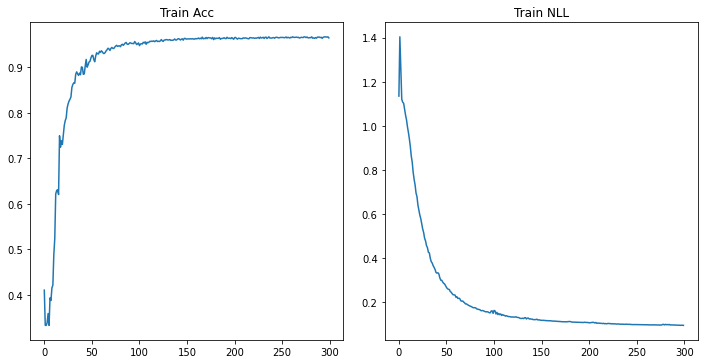

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
fig.tight_layout()
axes[0].plot(log_acc)
axes[1].plot(log_nll)
axes[0].title.set_text('Train Acc')
axes[1].title.set_text('Train NLL')

### Measuring Uncertainty - Total, Knowledge and Data Uncertainty
The Shannon entropy measures the information/uncertainty in a categorical distribution $\boldsymbol{p}=[p_1,p_2,\dots,p_K]$
$$H(p) = -\sum_{i=1}^K p_i\log{p_i}$$ 
The entropy is high when the probability is spread out over the classes and low when most of the probability is in a single class.

We can use entropy to measure the uncertainty in a prediction. Using the same notation as Malinin et al. [[1]], we call the average entropy of each prediction of the ensemble the **data uncertainty**. Let $\boldsymbol{p}^{(1)}, \dots,\boldsymbol{p}^{(M)}$ be the M predictive distributions of the ensemble, then the data uncertainty is
$$ \frac{1}{M}\sum_{i=1}^M H\Big(\boldsymbol{p}^{(i)}\Big) $$

The entropy of the mean prediction is called the **total uncertainty**, which is high if the data uncertainty is high or if the predictions are diverse. 

**Knowledge uncertainty** (think: uncertainty in parameters) is related to the diversity of the predictions, which we measure with the multi-distribution Jensen-Shannon divergence
$$ H\Big(\frac{1}{M}\sum_{i=1}^M \boldsymbol{p}^{(i)}\Big) - \frac{1}{M}\sum_{i=1}^M H\Big(\boldsymbol{p}^{(i)}\Big) $$
Indeed, the divergence measures the difference between total and data uncertainty. It is low when the predictions are similar and high when the predictions are different but confident.

Below, we visualize the data and knowledge uncertainty for our deep ensemble.

[1]:https://arxiv.org/abs/1905.00076

In [ ]:
def entropy(preds):
    preds = np.clip(preds, 1e-7, 1.0)
    return -np.sum( preds * np.log(preds), axis=1)

def js_terms(distributions):
    return entropy(np.mean(distributions, axis=0)), np.mean([entropy(p) for p in distributions], axis=0)

def visualize_predictions(X, y, params_list, min=-2.0, max=2.0, res=200, num_nets=1):
    xs = np.linspace(min, max, res)
    ys = np.linspace(min, max, res)
    N, M = len(xs), len(ys)
    xy = np.asarray([(_x,_y) for _x in xs for _y in ys])
    num_samples = xy.shape[0]

    predictions = [batched_predict(params, xy)[1] for params in params_list]
    predictions_ensemble = np.mean(predictions, axis=0)
    total, data = js_terms(predictions)

    Z, Z2, Z3 = np.zeros((N,M)), np.zeros((N,M)), np.zeros((N,M))
    indices = np.unravel_index(np.arange(num_samples), (N,M))
    Z[indices] = jnp.argmax(predictions_ensemble, axis=1)
    Z2[indices] = total - data
    Z3[indices] = data

    fig, axes = plt.subplots(2,2, figsize=(10,10))
    axes = axes.flatten()
    fig.tight_layout()

    axes[0].scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    axes[1].contourf(xs, ys, Z.T, cmap=plt.cm.Spectral, levels=50)
    axes[2].contourf(xs, ys, Z3.T, cmap='magma',levels=50)
    axes[3].contourf(xs, ys, Z2.T, cmap='magma', levels=50)

    axes[0].set_xlim([min, max]); axes[0].set_ylim([min, max]); 

    axes[0].title.set_text('Dataset')
    axes[1].title.set_text('Mean')
    axes[2].title.set_text('Data Uncertainty')
    axes[3].title.set_text('Knowledge Uncertainty')

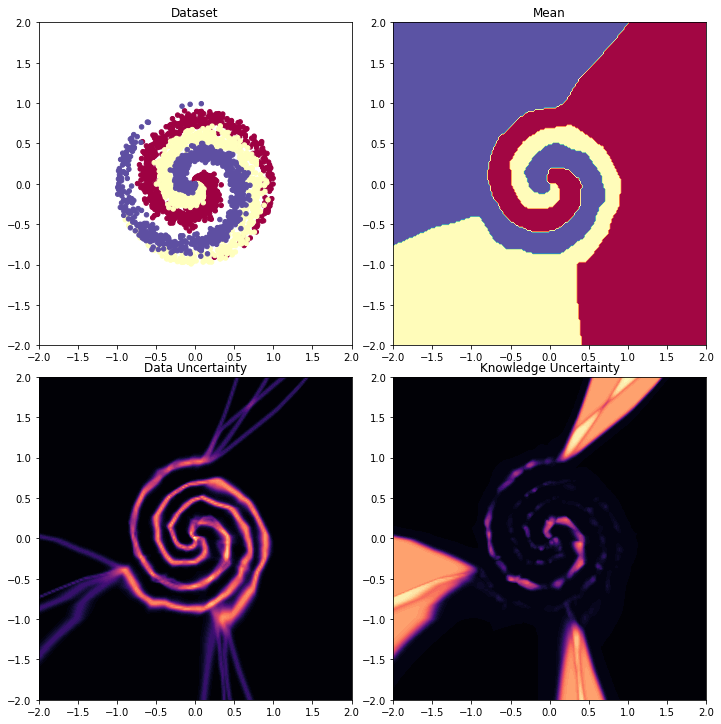

In [ ]:
visualize_predictions(X, y, params_all, num_nets=M)

where dark to light increases in value. 

**Discussion points:**
* Are there any regions where the network makes overconfident predictions? 
* Where is the ensemble most uncertain (high entropy)? Why?
* Where are the members of the ensemble the most diverse? Why?
* How does adversarial training affect the results? Why? 
* Finally, it is valuable for us to know how long did it take you to complete this practical?